Чтобы определить ускорение частицы, необходимо вычислить значения ее плотности и давления. Следующее уравнение суммирует массы соседей частицы, взвешенные с помощью функции ядра.

 $$ {\large p_i = \sum_{j}^{ } m_jW_{ij} } $$

 <p>\(W\) - функция сглаживающего ядра. Она показывает cтепень влияния, которое одна частица оказывает на другую:</p>

 $$ {\large  W_{ij} = \frac{315}{64\pi h^9}\left( h^2 - r^2 \right)^3 } $$

 <p>После определения плотности частицы давление может быть рассчитано по закону идеального газа:</p>

 $$ {\large P = K\left ( \rho - \rho_0 \right ) } $$


Теперь определим ускорение, вызванное массами, плотностями и давлениями окружающих частиц

 $$ {\large a_i = -\sum_{j}^{ }\frac{m_j}{m_i}\frac{P_i + P_j}
            {2p_ip_j}\bigtriangledown W_{ij} {r}_{ij} } $$

 $$ {\large \bigtriangledown W_{ij} = -\frac{45}{\pi h^6}\left ( h - r \right )^2 } $$

Учтём ускорение, возникающее из-за разности скоростей окружающих частей - вязкое ускорение

$$ {\large a_{v_i} = \varepsilon \sum_{j}^{ }\frac{m_j}{m_i}\frac{1}{p_j}
            \left ( v_j - v_i \right ) \bigtriangledown^2 W_{ij} {r}_{ij} } $$

  $$ {\large  W_{ij} = -\frac{r^3}{2h^3} + \frac{r^2}{h^2} + \frac{h}{2r} - 1 } $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import math

def W(r, h):
    if 0 <= r <= h:
        return 315.0 / (64.0 * np.pi * h**9) * (h**2 - r**2)**3
    return 0.0


def grad_W_pressure(x, y, h):
    r = np.sqrt(x ** 2 + y ** 2)
    if 0 < r <= h:
        return np.array([-45.0 / (np.pi * h**6 * r) * x * (h - r)**2,
                         -45.0 / (np.pi * h**6 * r) * y * (h - r)**2,])
    return np.array([0.0, 0.0])



def lap_W_viscosity(r, h):
    if 0 < r <= h:
        return  45.0 / (np.pi * h**6) * (h - r)
    return 0.0

In [2]:
def apply_bc(x, y, u, v, x_min, x_max, y_min, y_max, bdry_reflec):
    for i in range(len(x)):
        if x[i] < x_min:
            u[i] *= - bdry_reflec
            x[i] = x_min
          
        elif x[i] > x_max:
            u[i] *= - bdry_reflec
            x[i] = x_max
           
        if y[i] < y_min:
            v[i] *= - bdry_reflec
            y[i] = y_min
          
        elif y[i] > y_max:
            v[i] *= - bdry_reflec
            y[i] = y_max
           

In [3]:
def calculate_density(m, W, x, y, h):
    density = np.zeros(len(x))
    for i in range(len(x)):
        for j in range(len(x)):
            r = np.sqrt((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2)
            density[i] += m * W(r, h)
    return density

def calculate_pressure(k, rho, rho0):
    return k * (rho - rho0)

def acceleration(m, x, y, u, v, rho, P, g, viscosity, h, grad_W_pre, lap_W_viscosity):
    accel_x = np.zeros(len(x))
    accel_y = np.zeros(len(x))
    for i in range(len(x)):
        grav_x = 0.0
        grav_y = - g
        for j in range(len(x)):
            if i==j:
                continue
            dx = x[i] - x[j]
            dy = y[i] - y[j]
            rij = np.sqrt(dx ** 2 + dy ** 2)

            v_rel_x = u[i] - u[j]
            v_rel_y = v[i] - v[j]

            gradWij = grad_W_pressure(dx, dy , h)

            grad_P_x =  m * (P[i] + P[j]) * gradWij[0] / (2 * rho[i] * rho[j])
            grad_P_y =  m * (P[i] + P[j]) * gradWij[1] / (2 * rho[i] * rho[j])

            viscosity_x = m * viscosity * (u[j]-u[i]) * lap_W_viscosity(rij, h) / (rho[i]*rho[j])
            viscosity_y = m * viscosity * (v[j]-v[i]) * lap_W_viscosity(rij, h) / (rho[i]*rho[j])

            accel_x[i] +=  (grad_P_x + viscosity_x)
            accel_y[i] +=  (grad_P_y + viscosity_y)

        accel_x[i] +=  grav_x
        accel_y[i] +=  grav_y
    return accel_x, accel_y

def euler(x, y, u, v, dt, accel_x, accel_y):
    u += dt  * accel_x
    v += dt  * accel_y
    x += dt * u
    y += dt * v

In [4]:
N = 100            # Число частиц
h = 5              # Сглаживающая длина
width = 400        # Ширина
height = 500       # Высота
m = 1.             # Масса
rho0 = 1.          # Статическая плотность
dt = 0.05          # Шаг по времени
k = 20             # K 
g = 10             # гравитационное ускорение
final_time = 30    # полное время
viscosity = 0.5    # Коэффициент вязкости
bdry_reflec = 0.5  # коэффициент отражения
total_steps = int(final_time / dt)

x_min, y_min = 0 , 0
x_max, y_max = width, height

x = np.zeros(N)
y = np.zeros(N)


i=0
np.random.seed(42)
for yi in np.arange(y_min + 10, y_max, 7):
    for xi in np.arange(x_min + 10,  int((x_max - x_min) * 0.25), 9):
        if i < N:
            x[i],y[i] = xi + np.random.uniform(0, 2), yi + np.random.uniform(0, 2)
        i += 1
    pass

u = np.zeros(N)
v = np.zeros(N)
accel_x = np.zeros(N)
accel_y = np.zeros(N)
rho = np.zeros(N)
P = np.zeros(N)

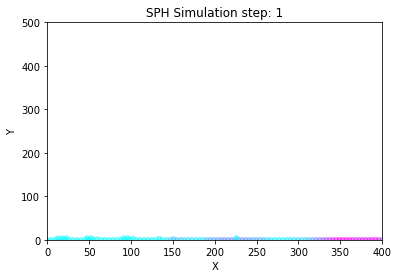

In [5]:
fig, ax = plt.subplots()
def animate(i, m, W, x, y, h, k, rho, rho0, u, v, dt, x_min, x_max, y_min, y_max, bdry_reflec):
    rho = calculate_density(m, W, x, y, h)
    P =calculate_pressure(k, rho, rho0)
    accel_x, accel_y = acceleration(m, x, y, u, v, rho, P, g, viscosity,h, grad_W_pressure, lap_W_viscosity)
    euler(x, y, u, v, dt, accel_x, accel_y)
    apply_bc(x, y, u, v, x_min, x_max, y_min, y_max, bdry_reflec)
    
    ax.clear()
    cval = rho.flatten()
    ax.set_xlim(0, x_max)
    ax.set_ylim(0, y_max)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'SPH Simulation step: {i+1}')
    scat = plt.scatter(x, y, c=cval, cmap=plt.cm.cool, s=20, alpha=0.5)


anim = FuncAnimation(fig=fig, func=animate, frames=total_steps, interval=30,
                               fargs=(m, W, x, y, h, k, rho, rho0, u, v, dt, x_min, x_max, y_min, y_max, bdry_reflec))

Writer = PillowWriter(fps=30)
anim.save('test5.mp4',  dpi = 300)
plt.show()  